# QF600 - Homework 6
*by Julian Chang*


> ## Behavioural Finance
> Assume Barberis, Huang, and Santos economy where investor receives utility from consumption as well as recent financial gain or loss. Use these parameters:
> $$
> \delta = 0.99, \quad \gamma = 1, \quad \lambda = 2
> $$

> Consumption growth has lognormal distribution:
> $$
> \log(\tilde{g}) = 0.02 + 0.02 \tilde{\epsilon}
> $$

> where ε is standard normal random variable. Simulate probability distribution for consumption > growth with (at least) 10^4 random draws from standard normal distribution.


In [9]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

Under optimal consumption: 
$$
R_f = e^{\rho + \gamma \mu - \frac{1}{2} \gamma^2 \sigma^2}
$$

In [10]:
# instantiate constants
delta = 0.99
gamma = 1
lambd = 2
R_f = 1.0303
# get estimate for g, generate random samples
samples = 10**5
epsilon = np.random.standard_normal(samples)
ln_g = 0.02 + 0.02 * epsilon
g = np.exp(ln_g)



> With these parameters, risk-free rate is around 3% per year:
> $$
> R_f = \frac{e^{0.0198}}{0.99} = R_f
> $$
 

>  Define x as one plus dividend yield for market portfolio:
> $$
> x = (1+\frac{P}{D}) \frac{D}{P} = 1+\frac{D}{P} 
> $$
 
> and define error term:
> $$
> e(x) = 0.99 b_0 E[v(x \tilde{g})] + 0.99x -1
> $$

> where utility from recent financial gain or loss is given by:
> $$
> v(R) = R - R_f \quad \text{for} R >= R_f
> $$
> $$
> v(R) = 2(R - R_f) \quad \text{for} R < R_f
> $$

> Solve for e(x) = 0 to find equilibrium value of x, using bisection search:

> Set x– = 1 and x+ = 1.1, and use simulated distribution of consumption growth to confirm that e(x–) < 0 and e(x+) > 0 ⇒ solution must lie between x– and x+
> Set x0 = 0.5*(x– + x+) and use simulated distribution of consumption growth to calculate e(x0)
> If |e(x0)| < 10–5, then you have converged to solution
> Otherwise if e(x0) < 0, then solution lies between x0 and x+ ⇒ repeat from step 2 with x– = x0
> Otherwise if e(x0) > 0, then solution lies between x– and x0 ⇒ repeat from step 2 with x+ = x0
> Repeat for b0 in range from 0 to 10, in increments of 0.1 (or less).


In [11]:
def exp_sample_v_xg(x: float, g: np.array, lambd: float) -> np.ndarray:
    """
    function to expected for a sample of random consumption growth v(xg) 
    Parameters:
        x (int or float): Input value for x which is 1 + D/P or one period return
        g (np.ndarray): Array of values for g, sample consumption growth (monte carlo)
        lambd (float): Lambda parameter for loss aversion multiplier
    return
        estimate of  v_xg as numpy array
    """
    xg = x * g

    return np.array([lambd * (R - R_f) if R < R_f else (R - R_f) for R in xg]).mean()

def e(x, g, lambd, b0)-> float:
    """
    Function to calculate error, e(x) based on the equilibrium condition for the price-dividend ratio of the market portfolio.
    
    Parameters:
        x (int or float):  x which is 1 + D/P or one period return
        g (np.ndarray): Array representing g, sample consumption growth (monte carlo)
        lambd (float): Lambda parameter for loss aversion multiplier
        b0 (float): This scaling factor adjusts the relative importance of financial gain/loss utility compared to consumption utility.

    Returns:
        float: Calculated error term e(x) as a floating-point number.
    """
    return 0.99 * b0 * exp_sample_v_xg(x, g, lambd) + 0.99 * x - 1

def bisection_search(func, x_low: float, x_high: float, iter: int, tol: float) -> tuple:
    """
    Performs the bisection search method to find a root of the function `func`.
    
    Parameters:
        func (Callable[[float], float]): The function for which the root is sought.
        x_low (float): The initial lower bound.
        x_high (float): The initial upper bound.
        iter (int): Maximum number of iterations.
        tol (float): Tolerance level for convergence.

    Returns:
        Optional[Tuple[float, int]]: The root approximation and iteration count if found within tolerance, else `None`.
    """
    for i in range(iter):
        x_0 = 0.5 * (x_low + x_high)
        e_0 = func(x_0)

        if abs(e_0) < tol:
            return x_0, i
        elif e_0 < 0:
            x_low = x_0
        else:
            x_high = x_0
    
    return None

In [12]:
ls_b0 = []
ls_x0 = []
ls_iters = []

# iterate through values of b0 to get x0 values and save results
for b0_ in np.linspace(0,10,130):
    x_neg = 1
    x_pos = 1.2

    x0, iterations = bisection_search(lambda x: e(x, g, lambd, b0_), x_neg, x_pos, iter=10**7, tol=10**-5)
    ls_b0.append(b0_)
    ls_x0.append(x0)
    ls_iters.append(iterations)




> Calculate price-dividend ratio for market portfolio:
> $$
> E(\tilde{R}_m) = E(x \tilde{g}) = x e^{0.0202}
> $$
 
> Plot price-dividend ratio (on vertical axis) vs b0.


In [13]:
# get market portfolio returns
# monte carlo approach
market_exp = [(x0*g).mean() for x0 in np.array(ls_x0)]
# analytical approach
market_exp1 = [x0*np.exp(.0202) for x0 in np.array(ls_x0)]

In [14]:
df = pd.DataFrame({
                    'b0': ls_b0, 
                   'x0': ls_x0, 
                   'P/D': 1/ (np.array(ls_x0)-1),
                   'Expected Market Return': market_exp,
                   'Expected Market Return_1': market_exp1
                   })
df['Equity Premium(%)'] = (df['Expected Market Return'] - R_f) * 100
df['Equity Premium_1(%)'] = (df['Expected Market Return_1'] - R_f) * 100

df

,b0,x0,P/D,Expected Market Return,Expected Market Return_1,Equity Premium(%),Equity Premium_1(%)
0,0.000000,1.010107,98.937198,1.030608,1.030719,0.030806,0.041907
1,0.077519,1.010645,93.944954,1.031156,1.031267,0.085607,0.096714
2,0.155039,1.011084,90.220264,1.031604,1.031716,0.130445,0.141556
3,0.232558,1.011438,87.427962,1.031966,1.032077,0.166564,0.177679
4,0.310078,1.011743,85.155925,1.032277,1.032388,0.197700,0.208819
...,...,...,...,...,...,...,...
125,9.689922,1.015045,66.466531,1.035646,1.035758,0.534602,0.545757
126,9.767442,1.015048,66.453052,1.035649,1.035761,0.534914,0.546068
127,9.844961,1.015051,66.439578,1.035652,1.035764,0.535225,0.546380
128,9.922481,1.015054,66.429476,1.035655,1.035766,0.535459,0.546613


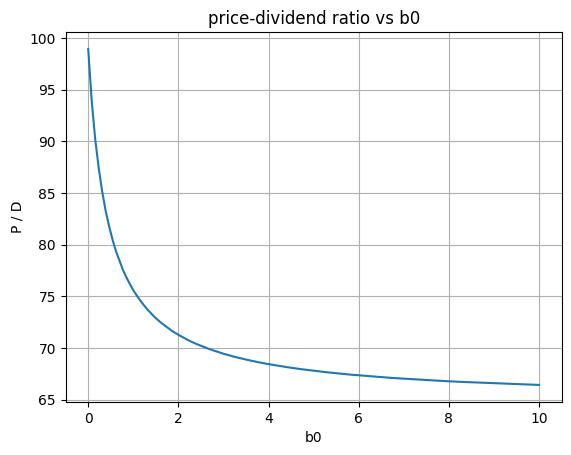

In [15]:
plt.plot(df['b0'], df['P/D'])
plt.xlabel('b0')
plt.ylabel('P / D')
plt.title('price-dividend ratio vs b0')
plt.grid()
plt.show()


> Calculate expected market return:
> Plot equity premium (on vertical axis) vs b0.


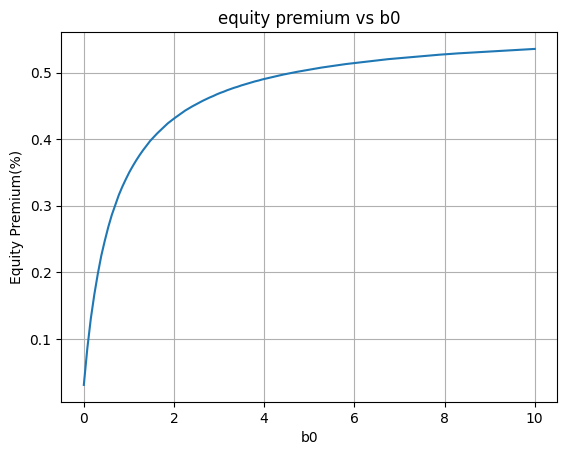

In [16]:
plt.plot(df['b0'], df['Equity Premium(%)'])
plt.xlabel('b0')
plt.ylabel('Equity Premium(%)')
plt.title('equity premium vs b0')
plt.grid()
plt.show()


> Briefly describe (in words, without using mathematical equations or formulas) main characteristics of v(∙) as well as economic significance and implications of b0 and λ.

*$v(0)$ is a piecewise-linear Utility Function*: Measures utility from recent gains and losses. Gains yield positive utility, while losses cause a larger, amplified negative by $\lambda$ utility response due to loss aversion.

​
*$b_0$*: This scaling factor adjusts the relative importance of financial gain/loss utility compared to consumption utility. A higher $b_0$ means recent financial outcomes significantly influence overall satisfaction, amplifying the impact of market performance on an investor’s well-being. At 0 there is no loss aversion and at infinity there is only loss aversion considered by the representative investor.


*$\lambda$*: This parameter reflects loss aversion—the degree to which investors are more sensitive to financial downside risk than to equivalent gains. When $\lambda$ is high, investors strongly avoid losses, impacting risk tolerance and increasing demand for safer assets. In turn, this loss aversion affects market dynamics, as a higher 
$\lambda$ can lead to higher equity premiums.


Together, $b_0$ and $\lambda$ help explain why investors might demand compensation for bearing risks, even in markets where consumption is smooth.